In [8]:
!pip install lightgbm
!pip3 install --upgrade pandas
!pip install -U imbalanced-learn
!pip install shap
!pip install keras

Requirement already up-to-date: pandas in /usr/local/envs/py3env/lib/python3.5/site-packages (0.23.4)
Requirement already up-to-date: imbalanced-learn in /usr/local/envs/py3env/lib/python3.5/site-packages (0.4.2)
  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fc/94/74e0fa783d3fc07e41715973435dd051ca89c550881b3454233c39c73e69/Keras_Preprocessing-1.0.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3f/c4/2ff40221029f7098d58f8d7fb99b97e8100f3293f9856f0fb5834bef100b/Keras_Applications-1.0.6-py2.py3-none-any.whl


In [5]:
import pandas as pd
import numpy as np
from io import BytesIO as BI

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore') 

In [3]:
#%%gcs list --objects "gs://deft-tube-217903/Home Credit LabelEncode"

In [6]:
%gcs read --object "gs://deft-tube-217903/Home Credit LabelEncode/Selected_Features_3Decimals.csv" --variable csv_as_bytes1

In [7]:
app_train = pd.read_csv(BI(csv_as_bytes1))
app_train.head()

AMT_ANNUITY  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  AMT_REQ_CREDIT_BUREAU_DAY  \
0       -0.166           -0.505             0.142                      0.359   
1        0.592            1.601             0.427                      0.359   
2       -1.404           -1.090            -0.427                      0.359   
3        0.178           -0.651            -0.143                     -2.425   
4       -0.362           -0.067            -0.200                      0.359   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_MON  \
0                       0.367                     -0.100   
1                       0.367                     -0.100   
2                       0.367                     -0.100   
3                      -2.469                     -1.147   
4                       0.367                     -0.100   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                     -0.111                       0.262   
1                     -0.111                       0.262   
2                     -0.111                       0.262   
3                     -1.279                      -2.229   
4                     -0.111                       0.262   

   AMT_REQ_CREDIT_BUREAU_YEAR  APARTMENTS_AVG   ...    income_per_person  \
0                      -0.254           0.841   ...                1.079   
1                      -0.754           0.968   ...                0.413   
2                      -0.754          -0.976   ...               -0.253   
3                      -1.254          -0.976   ...               -0.253   
4                      -0.754          -0.976   ...                0.280   

   payment_rate  phone_to_birth_ratio  phone_to_employ_ratio  \
0         0.313                 1.016                  0.195   
1        -1.161                -0.245                 -0.045   
2        -0.165                -0.363                  0.603   
3         1.833                -0.548                 -0.155   
4        -0.493                -0.136                 -0.119   

   child_to_non_child_ratio  income_per_non_child  credit_per_person  \
0                    -0.559                 0.739              0.320   
1                    -0.559                 0.222              1.247   
2                    -0.559                -0.295             -0.729   
3                    -0.559                -0.295             -0.647   
4                    -0.559                 0.118              0.730   

   credit_per_child  credit_per_non_child  TARGET  
0            -0.238                 0.146       1  
1             2.070                 1.037       0  
2            -0.945                -0.862       0  
3            -0.483                -0.783       0  
4             0.039                 0.541       0  

[5 rows x 782 columns]

In [6]:
%gcs read --object "gs://deft-tube-217903/Home Credit LabelEncode/Selected_Test_3Decimals.csv" --variable csv_as_bytes2

In [7]:
app_test = pd.read_csv(BI(csv_as_bytes2))
app_test.head()

AMT_ANNUITY  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  AMT_REQ_CREDIT_BUREAU_DAY  \
0       -0.225           -0.846            -0.218                     -2.425   
1       -1.301           -1.090            -0.560                     -2.425   
2       -0.735           -0.846            -0.200                      0.359   
3        0.592           -0.237            -0.332                      0.359   
4       -0.970           -0.651            -0.080                      0.359   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_MON  \
0                      -2.469                     -1.147   
1                      -2.469                     -1.147   
2                       0.367                     -0.100   
3                       0.367                      0.947   
4                       0.367                     -0.100   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                     -1.279                      -2.229   
1                     -1.279                      -2.229   
2                      1.057                       0.262   
3                     -0.111                       0.262   
4                     -0.111                       0.262   

   AMT_REQ_CREDIT_BUREAU_YEAR  APARTMENTS_AVG   ...    income_per_person  \
0                      -1.254          -0.976   ...               -0.534   
1                      -1.254          -0.976   ...               -0.563   
2                       1.745           1.408   ...               -0.319   
3                       0.746          -0.976   ...               -0.696   
4                       1.745           0.845   ...               -0.179   

   payment_rate  phone_to_birth_ratio  phone_to_employ_ratio  \
0         2.033                -1.129                 -0.200   
1        -0.118                -0.663                 -0.200   
2         0.184                -0.076                 -0.201   
3         1.137                -0.553                  0.011   
4        -0.775                -0.488                 -0.078   

   child_to_non_child_ratio  income_per_non_child  credit_per_person  \
0                     0.628                -0.364             -0.941   
1                    -0.559                -0.537             -0.626   
2                    -0.559                -0.347             -0.701   
3                     1.815                -0.468             -0.816   
4                    -0.559                -0.238             -0.556   

   credit_per_child  credit_per_non_child  TARGET  
0            -0.984                -0.918     NaN  
1            -0.876                -0.763     NaN  
2            -0.556                -0.835     NaN  
3            -0.906                -0.528     NaN  
4            -0.360                -0.696     NaN  

[5 rows x 782 columns]

In [11]:
#Splitting data
response='TARGET'
predictors= [col for col in app_train.columns if col != response]

### Train/Test Split + Undersampling

In [12]:
import imblearn.utils
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy = 0.7, random_state=0)
X_resampled, y_resampled = rus.fit_resample(app_train[predictors], app_train[response])

ImportError: cannot import name 'Parallel'

In [15]:
X_resampled_df = pd.DataFrame(X_resampled, columns= predictors)
X_resampled_df.head()

AMT_ANNUITY  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  AMT_REQ_CREDIT_BUREAU_DAY  \
0        0.158           -0.116             0.427                      0.359   
1       -1.178           -0.846            -0.332                      0.359   
2        1.449            0.371             0.047                      0.359   
3       -0.327            0.615             0.332                      0.359   
4        0.808           -0.177             0.142                      0.359   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_MON  \
0                       0.367                     -0.100   
1                       0.367                     -0.100   
2                       0.367                     -0.100   
3                       0.367                      0.947   
4                       0.367                     -0.100   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                     -0.111                       0.262   
1                     -0.111                       0.262   
2                     -0.111                       0.262   
3                     -0.111                       0.262   
4                     -0.111                       0.262   

   AMT_REQ_CREDIT_BUREAU_YEAR  APARTMENTS_AVG          ...           \
0                       2.245          -0.976          ...            
1                      -0.254          -0.976          ...            
2                      -0.754          -0.976          ...            
3                       0.246           1.044          ...            
4                       0.246          -0.976          ...            

   income_credit_percentage  income_per_person  payment_rate  \
0                     0.140              0.413        -0.108   
1                     0.000             -0.622        -0.404   
2                    -0.292             -0.326         0.603   
3                    -0.150              1.523        -1.088   
4                    -0.033              0.080         0.876   

   phone_to_birth_ratio  phone_to_employ_ratio  child_to_non_child_ratio  \
0                 0.840                 -0.201                    -0.559   
1                -0.234                  0.353                     0.628   
2                 0.580                 -0.144                     0.628   
3                 1.245                 -0.078                    -0.559   
4                -0.434                 -0.143                    -0.559   

   income_per_non_child  credit_per_person  credit_per_child  \
0                 0.222             -0.143             0.196   
1                -0.468             -0.961            -1.004   
2                -0.123             -0.330            -0.366   
3                 1.084              1.703             0.694   
4                -0.037             -0.230             0.079   

   credit_per_non_child  
0                -0.299  
1                -0.946  
2                -0.036  
3                 1.476  
4                -0.382  

[5 rows x 781 columns]

In [21]:
y_resampled_df = pd.DataFrame(y_resampled, columns=['TARGET'])
y_resampled_df.head()

TARGET
0       0
1       0
2       0
3       0
4       0

In [23]:
resampled_df_40 = X_resampled_df.join(y_resampled_df)
resampled_df_40.to_csv('resampled_df_40')

In [10]:
X_resampled.shape

(60289, 781)

In [11]:
y_resampled.mean()

0.4117666572674949

From now on, we use X_resampled and y_resampled as the training data. Below details modelling and parameter tuning. 

# Randomised Search CV

### Logistic Regression

In [9]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()

In [52]:
#Hyperparameter tuning

param_grid = {
    'loss' : ['log'],
    'penalty': ['elasticnet', 'none'],
    'alpha': [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007],
    'l1_ratio': [0, 0.2, 0.3, 0.4, 0.5, 0.6],
    'class_weight': ['balanced', None],
    'learning_rate': ['optimal']
}


In [10]:
logit_space = {
    'loss' : hp.choice('loss',['log']),
    'penalty': hp.choice('penalty',['elasticnet', 'none']),
    'alpha': hp.choice('alpha',[0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]),
    'l1_ratio': hp.choice('l1_ratio',[0, 0.2, 0.3, 0.4, 0.5, 0.6]),
    'class_weight': hp.choice('class_weight',['balanced', None]),
    'learning_rate': hp.choice('learning_rate',['optimal'])
}

In [54]:
%%time
logit_rcv = RandomizedSearchCV(model, param_grid, scoring='roc_auc', cv = 5, 
                             return_train_score=False, n_jobs= -1, verbose = False, n_iter = 40)

logit_rcv.fit(X_resampled, y_resampled)

CPU times: user 7.83 s, sys: 1.88 s, total: 9.72 s
Wall time: 1min 52s


In [55]:
logit_clf = logit_rcv.best_estimator_
logit_df = pd.DataFrame(logit_rcv.cv_results_).sort_values('mean_test_score', ascending = False)
logit_df.to_csv('logistic_random_results')

### Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0)

In [13]:
#Hyperparameter tuning

param_grid = {
    'n_estimators' : [30, 45, 60],
    'min_samples_split': [2, 20, 200],
    'min_samples_leaf': [1, 10, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': list(np.arange(3, 16, 3)),
    'class_weight': ['balanced', None]
}


In [12]:
RF_space = {
    'n_estimators': hp.quniform('n_estimators', 30, 60, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 200,1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1,100,1),
    'criterion': hp.choice('criterion', {'gini','entropy'}),
    'max_depth': hp.quniform('max_depth', 3, 20,1),
    'class_weight': hp.choice('class_weight', {'balanced', None})                                        
}

In [14]:
%%time
rf_rcv = RandomizedSearchCV(model, param_grid, scoring='roc_auc', cv = 3, 
                             return_train_score=False, n_jobs= -1, verbose = False, n_iter = 50)

rf_rcv.fit(X_resampled, y_resampled)

CPU times: user 51.9 s, sys: 1.52 s, total: 53.5 s
Wall time: 8min 45s


In [19]:
rf_df = pd.DataFrame(rf_rcv.cv_results_).sort_values('mean_test_score')
rf_clf = rf_rcv.best_estimator_
rf_df.to_csv('Random_Forest_random_results')

### Light GBM

In [20]:
#Hyperparameter tuning

param_grid = {
    'n_estimators' : [500, 550, 600, 650],
    'max_bin': list(range(160, 240, 20)),
    'max_depth': list(np.arange(6, 11, 1)),
    'num_leaves': list(range(18, 25, 2)),
    'min_data_in_leaf': list(range(20, 80, 10)),
    'min_child_samples': list(range(30, 80, 10)),
    'lambda_l1': list([0, 0.4, 0.5, 0.7]),
    'lambda_l2': list([0, 0.5, 0.6, 0.7, 0.8]),
    'reg_alpha': list([0.1, 0.3, 0.5, 0.7]),
    'reg_lambda': list([0, 0.1]),
    'learning_rate': list([0.03, 0.05, 0.07, 0.09, 0.11, 0.13]),
    # 'subsample_for_bin': list(range(10000, 30001, 10000)),
    'colsample_bytree': list(np.linspace(0.6, 1, 5)),
    'subsample': list(np.linspace(0.75, 1, 8)),
    'subsample_freq': list(range(5, 30, 5)),
    'is_unbalance': [True, False],
    'bagging_freq': list(range(5, 30, 5)),
    'bagging_fraction': list([0.7, 0.8]),
    'feature_fraction': list([0.2, 0.3, 0.35, 0.4]),
    'num_iterations': list([120, 130, 140, 150])
}


In [13]:
# Define the search space

lgb_space = {
    'n_estimators': hp.quniform('n_estimators', 500, 650, 10),
    'max_bin': hp.quniform('max_bin', 160, 240, 10),
    'max_depth': hp.quniform('max_depth', 6, 11, 1),
    'num_leaves': hp.quniform('num_leaves', 18, 25, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 20, 80, 10),
    'min_child_samples': hp.quniform('min_child_samples',30, 80, 10),
    'lambda_l1': hp.uniform('lambda_l1', 0.0, 0.7),
    'lambda_l2': hp.uniform('lambda_l2', 0.0, 0.8),
    'reg_alpha': hp.uniform('reg_alpha',0.1, 0.7),
    'reg_lambda': hp.uniform('reg_lambda',0.0, 0.2),
    'learning_rate': hp.uniform('learning_rate',0.03, 0.13),
    'colsample_bytree': hp.choice('colsample_bytree', np.linspace(0.6, 1, 5, dtype = float)),
    'subsample': hp.choice('subsample', np.linspace(0.75, 1, 8, dtype = float)),
    'subsample_freq': hp.quniform('subsample_freq', 5, 30, 5),
    'is_unbalance': hp.choice('is_unbalance',[True, False]),
    'bagging_freq': hp.quniform('bagging_freq', 5, 30, 5),
    'bagging_fraction': hp.choice('bagging_fraction', [0.7, 0.8]),
    'feature_fraction': hp.choice('feature_fraction', [0.2, 0.3, 0.35, 0.4]),
    'num_iterations': hp.choice('num_iterations', [120, 130, 140, 150]),

}
                                

In [21]:
%%time
model = lgb.LGBMClassifier()
lgb_rcv = RandomizedSearchCV(model, param_grid, scoring='roc_auc', cv = StratifiedKFold(5), 
                             return_train_score=False, n_jobs= -1, n_iter = 30, verbose = False)
lgb_rcv.fit(X_resampled, y_resampled)

CPU times: user 36.8 s, sys: 1.91 s, total: 38.7 s
Wall time: 10min 22s


In [24]:
lgb_df = pd.DataFrame(lgb_rcv.cv_results_).sort_values('mean_test_score', ascending = False)
lgb_clf = lgb_rcv.best_estimator_
lgb_df.to_csv('lgb_random_results')

In [143]:
lgb.LGBMClassifier(**lgb_df['params'][0])

LGBMClassifier(bagging_fraction=0.8, bagging_freq=20, boosting_type='gbdt',
        class_weight=None, colsample_bytree=0.6, feature_fraction=0.4,
        importance_type='split', is_unbalance=False, lambda_l1=0.7,
        lambda_l2=0.5, learning_rate=0.07, max_bin=220, max_depth=6,
        min_child_samples=70, min_child_weight=0.001, min_data_in_leaf=60,
        min_split_gain=0.0, n_estimators=600, n_jobs=-1,
        num_iterations=120, num_leaves=20, objective=None,
        random_state=None, reg_alpha=0.1, reg_lambda=0, silent=True,
        subsample=0.75, subsample_for_bin=200000, subsample_freq=5)

In [46]:
# fit the best estimator using the resampled training set
lgb_clf.fit(X_resampled, y_resampled, verbose = True)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=25, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.35,
        importance_type='split', is_unbalance=False, lambda_l1=0.7,
        lambda_l2=0, learning_rate=0.11, max_bin=160, max_depth=9,
        min_child_samples=50, min_child_weight=0.001, min_data_in_leaf=50,
        min_split_gain=0.0, n_estimators=500, n_jobs=-1,
        num_iterations=150, num_leaves=22, objective=None,
        random_state=None, reg_alpha=0.1, reg_lambda=0, silent=True,
        subsample=0.8928571428571428, subsample_for_bin=200000,
        subsample_freq=10)

In [58]:
SK_ID = pd.read_csv('application_test.csv')

In [59]:
SK_ID = SK_ID.drop(columns = SK_ID.columns[1:])
SK_ID['TARGET'] = y_predict[:,1]

In [60]:
#feature_train_matrix.to_csv('Feature_Matrix_train.csv', encoding='utf-8', index=False)
SK_ID.to_csv('0.7691predictions.csv', encoding='utf-8', index=False)
!gsutil cp '0.7691predictions.csv' 'gs://deft-tube-217903/Home Credit LabelEncode/0.7691predictions.csv'

Copying file://0.7691predictions.csv [Content-Type=text/csv]...
/ [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation completed over 1 objects/1.2 MiB.                                      


# Bayesian Hyperoptimisation

In [1]:
#Only need to run this once. This was what was causing the bugs
!pip install --upgrade networkx

  Found existing installation: networkx 2.1
    Uninstalling networkx-2.1:
      Successfully uninstalled networkx-2.1


In [7]:
import networkx
import hyperopt
from hyperopt import hp

In [4]:
#Only need to run this once as well
!pip install git+https://github.com/hyperopt/hyperopt.git

  Cloning https://github.com/hyperopt/hyperopt.git to /tmp/pip-req-build-qgjn1pez
  Using cached https://files.pythonhosted.org/packages/93/bf/d5234f8dc5eaae6d8391154f282dbefb7f82c2d8305af60cb5face86e880/pymongo-3.7.2-cp35-cp35m-manylinux1_x86_64.whl
  Running setup.py bdist_wheel for hyperopt ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ezapqf0/wheels/41/81/24/15fcba6ebbe35fc157f711f37249cbf4229bb3754ff607fd21
Successfully built hyperopt


In [32]:
#Code to find default values of functions
#import inspect
#def get_default_args(func):
#  signature = inspect.signature(func)
#  return {
#    k:v.default
#    for k,v in signature.parameters.items()
#    if v.default is not inspect.Parameter.empty
#  }

In [22]:
from hyperopt import hp
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK

def objective_lgb(params):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
        
    for parameter_name in ['n_estimators', 'num_leaves', 'subsample_freq', 'silent', 'min_child_samples', 
                           'max_depth', 'subsample_for_bin', 'min_data_in_leaf', 'bagging_freq', 'max_bin']:
      if parameter_name in params.keys():
        params[parameter_name] = int(params[parameter_name])
         
    model = lgb.LGBMClassifier(boosting_type= 'gbdt', **params)
    
    cv_results = cross_val_score(model, X_resampled, y_resampled, cv = 3, scoring='roc_auc')
  
    # Extract the best score
    best_score = max(cv_results)
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status':STATUS_OK}
    
def objective_rf(params):
    
    for parameter_name in ['n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_depth']:
        params[parameter_name] = int(params[parameter_name])
         
    model = RandomForestClassifier(random_state=0, **params)
    cv_results = cross_val_score(model, X_resampled, y_resampled, cv = 3, scoring='roc_auc')
    best_score = max(cv_results)
    loss = 1 - best_score
    return {'loss': loss, 'params': params, 'status':STATUS_OK}
  
  
def objective_lr(params):
         
    model = SGDClassifier(**params)
    cv_results = cross_val_score(model, X_resampled, y_resampled, cv = 3, scoring='roc_auc')
    best_score = max(cv_results)
    loss = 1 - best_score
    return {'loss': loss, 'params': params, 'status':STATUS_OK}
  
    

In [34]:
#Optimization code
from hyperopt import tpe
tpe_algorithm = tpe.suggest

from hyperopt import Trials
from hyperopt import fmin
MAX_EVALS = 50

# Optimize

def optimise_hyperopt(objective_fn, space):
  bayes_trials = Trials()
  best = fmin(fn = objective_fn, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)
  model_pd = pd.DataFrame(bayes_trials.results).sort_values('loss')
  model_pd['auc'] = 1 - model_pd['loss']
  return model_pd

In [36]:
%%time 
Logistic_hyperopt = optimise_hyperopt(objective_lr, logit_space)

CPU times: user 6min 46s, sys: 3.77 s, total: 6min 50s
Wall time: 5min 19s


In [24]:
%%time
lgb_hyperopt = optimise_hyperopt(objective_lgb, lgb_space)

CPU times: user 1h 30min 3s, sys: 1min 6s, total: 1h 31min 10s
Wall time: 15min 14s


In [30]:
%%time
rf_hyperopt = optimise_hyperopt(objective_rf, RF_space)

CPU times: user 42min 50s, sys: 0 ns, total: 42min 50s
Wall time: 42min 51s


In [35]:
# lgb_hyperopt.to_csv('lgb_hyperopt_results')
# rf_hyperopt.to_csv('rf_hyperopt_results')
# Logistic_hyperopt.to_csv('logistic_hyperopt_results')

## Model Evaluation

## Feature Importance

In [77]:
!pip install shap

    100% |████████████████████████████████| 184kB 1.2MB/s ta 0:00:01
    89% |████████████████████████████▌   | 40kB 5.0MB/s eta 0:00:011    100% |████████████████████████████████| 51kB 5.0MB/s 
  Running setup.py bdist_wheel for shap ... done
  Stored in directory: /content/.cache/pip/wheels/ef/55/5e/1b7fab6740a33bcae0de4938c110a9149d7e3f590b4f4510bf
Successfully built shap


In [115]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_train.iloc[:100,:])

In [116]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value[1], shap_values[1], X_train.iloc[:100,:])

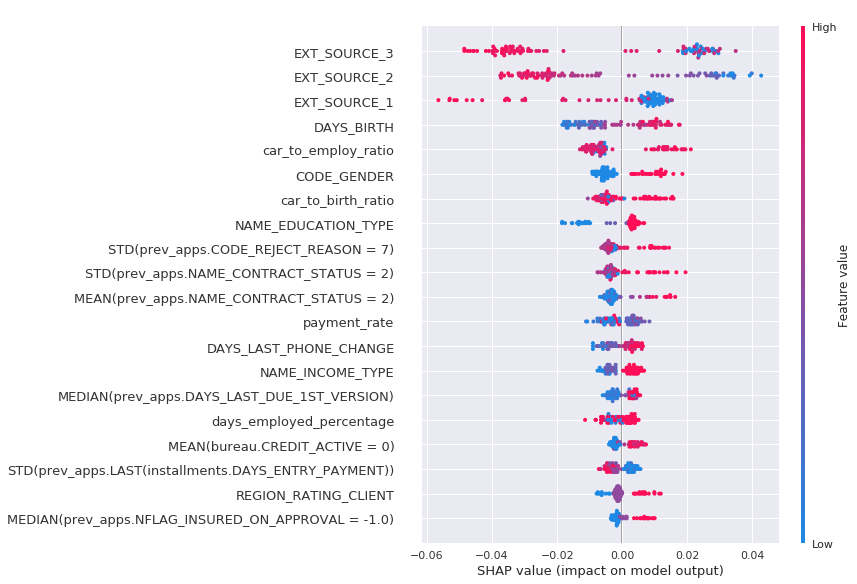

In [119]:
shap.summary_plot(shap_values[1], X_train.iloc[:100,:])